In [3]:
import sympy as sym
import numpy as np
import scipy as sp

from pygears.transformation import symbolic_transformation, numeric_transformation

t, x, m, xw = sym.symbols(["t", "x", "m", "xw"])
s, alpha, n_t, y, phi = sym.symbols(["s", "alpha", "n_t", "y", "phi"])
r = sym.Function("r")(x, y)
z = sym.Function("z")(x, y, t)

In [4]:
dp = sym.sqrt( (x - xw)**2 + z**2)
dp

sqrt((x - xw)**2 + z(x, y, t)**2)

In [5]:
sym.simplify(sym.diff(dp, x))

(x - xw + z(x, y, t)*Derivative(z(x, y, t), x))/sqrt((x - xw)**2 + z(x, y, t)**2)

In [ ]:
(x - xw + z(x,y,t) * dz_dx(x,y,t) ) / np.sqrt((x - xw)**2 + z(x,y,t)**2 )

In [6]:
z = m * n_t * sym.asin(y / r) / 2 + (r - xw) * sym.tan(alpha) + t
z

m*n_t*asin(y/r(x, y))/2 + t + (-xw + r(x, y))*tan(alpha)

In [7]:
sym.simplify(sym.diff(z, x))

-m*n_t*y*Derivative(r(x, y), x)/(2*sqrt(-y**2/r(x, y)**2 + 1)*r(x, y)**2) + tan(alpha)*Derivative(r(x, y), x)

In [ ]:
np.tan(alpha)*dr_dx(x,y) - module * n_t * y * d_r(x, y) / 2 / np.sqrt(1 - y**2/r(x, y)**2) / r(x, y)**2

In [41]:
r = sym.sqrt(x**2 + y**2)
r

sqrt(x**2 + y**2)

In [42]:
sym.diff(r, x)

x/sqrt(x**2 + y**2)

In [ ]:
x / r(x, y)

PATH_TO_FREECAD_LIBDIR not specified, using default FreeCAD version in /Users/lo/projects/freecad/freecad.gears/.pixi/envs/default/lib
t_start_1: -3.111447653720825
t_start_0: 3.8893095671510314
t0: 3.918003320200202, min: 0.36578136487102625
t1: -3.198847303563012, min: 0.36578136487102625
t0_start: -3.111447653720825, min: 0.010941793281827223
t1_start: 3.8893095671510314, min: -0.0030845690948233754
t0: 3.269498646278975, min: 0.44186895876036775
t1: -3.642880473656599, min: 0.44186895876036775
t0_start: -3.111447653720825, min: 0.06633302892696695
t1_start: 3.8893095671510314, min: 0.06569276335972905
t0: 3.111447653720826, min: 0.45461035737330546
t1: -3.889309567151029, min: 0.45461035737330546
t0_start: -3.111447653720825, min: 0.09643386212545335
t1_start: 3.8893095671510314, min: 0.07726137411494792
t0: 3.4753294082942467, min: 0.391587937911889
t1: -3.9404682933633146, min: 0.391587937911889
t0_start: -3.111447653720825, min: 0.1018769815432526
t1_start: 3.8893095671510314, m

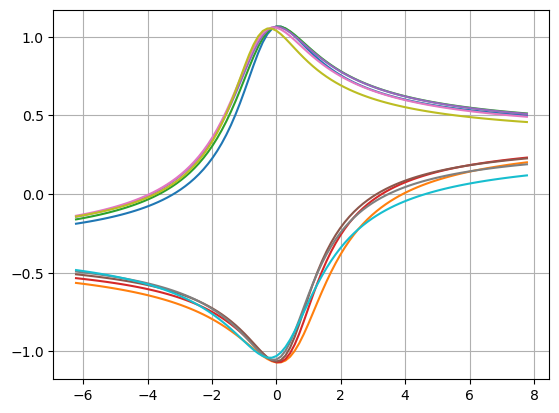

In [1]:
import scipy as sp
import numpy as np
from freecad import part
from freecad import app
from pygears.transformation import numeric_transformation
import matplotlib.pyplot as plt

debug = False
def compute_involute(module=1, teeth=15, height=3, worm_pitch_diameter=10, num_threads=1, alpha=np.deg2rad(20), clearence=0.25, head=0.):
    y = 0.
    xw = worm_pitch_diameter / 2
    
    def r(x, y):
        return (x**2 + y**2)**(0.5)

    def dr_dx(x, y):
        return x / r(x, y)
    
    def z(x, y, t):
        r_xy = r(x, y)
        return module * num_threads * np.arcsin(y / r_xy) / 2 + (r_xy - xw) * np.tan(alpha) + t

    def dz_dx(x, y, t):
        r_xy = r(x, y)
        return np.tan(alpha) * dr_dx(x,y) - module * num_threads * y * dr_dx(x, y) / 2 / np.sqrt(1 - y**2/r_xy**2) / r_xy**2

    def distance_pw(x, y, t):
        return np.sqrt((xw - x) ** 2 + z(x, y, t) ** 2)

    def d_distance_pw_dx(x, y, t):
        return (x - xw + z(x,y,t) * dz_dx(x,y,t)) / np.sqrt((x-xw) ** 2 + z(x,y,t) ** 2)

    def min_root(y, t):
        r0 = xw +  module * (1 + clearence)
        x0 = np.sqrt(r0**2 - y**2)
        return d_distance_pw_dx(x0, y, t)
        
    def min_head(y, t):
        r1 = xw -  module * (1 + head)
        x1 = np.sqrt(r1**2 - y**2)
        return d_distance_pw_dx(x1, y, t)
        
    xyz = []        
    r0 = xw -  module * (1 + head)
    r1 = xw +  module * (1 + clearence)
    t_start_0 = (r0 - xw) * (np.tan(alpha) + 1. / np.tan(alpha))
    t_start_1 = (r1 - xw) * (np.tan(alpha) + 1. / np.tan(alpha))
    print(f"t_start_1: {t_start_0}")
    print(f"t_start_0: {t_start_1}")

    for y in np.linspace(- height / 2, height / 2, 5):
        t_i = np.linspace(t_start_0 * 2, t_start_1 * 2, 100)
        plt.plot(t_i, [min_root(y, t) for t in t_i])
        plt.plot(t_i, [min_head(y, t) for t in t_i])
        plt.grid()
        t0 = sp.optimize.root(lambda t: min_head(y, t)**2, t_start_1).x[0]
        t1 = sp.optimize.root(lambda t: min_root(y, t)**2, t_start_0).x[0]
        print(f"t0: {t0}, min: {min_root(y, t0)**2}")
        print(f"t1: {t1}, min: {min_root(y, t0)**2}")        
        print(f"t0_start: {t_start_0}, min: {min_root(y, t_start_0)}")
        print(f"t1_start: {t_start_1}, min: {min_head(y, t_start_1)}")
        for t in np.linspace(t0, t1, 10):
            x_t = sp.optimize.root(lambda x: d_distance_pw_dx(x, y, t), xw).x[0]
            z_t = z(x_t, y, t)
            point = App.Vector(x_t, y, z_t)
            part.show(part.Point(point).toShape())

compute_involute()

In [3]:
import scipy as sp
import numpy as np
from freecad import part
from freecad import app
from pygears.transformation import numeric_transformation
import matplotlib.pyplot as plt

debug = False
def compute_involute(module=1, teeth=15, height=3, worm_pitch_diameter=10, num_threads=1, alpha=np.deg2rad(20), clearence=0.25, head=0.):
    y = 0.
    xw = worm_pitch_diameter / 2
    rw = module * teeth / 2.  # the pitch radius of the gear (not the worm!)
    
    def r(x, y):
        return (x**2 + y**2)**(0.5)

    def dr_dx(x, y):
        return x / r(x, y)
    
    def z(x, y, t):
        r_xy = r(x, y)
        return module * num_threads * np.arcsin(y / r_xy) / 2 + (r_xy - xw) * np.tan(alpha) + t

    def dz_dx(x, y, t):
        r_xy = r(x, y)
        return np.tan(alpha) * dr_dx(x,y) - module * num_threads * y * dr_dx(x, y) / 2 / np.sqrt(1 - y**2/r_xy**2) / r_xy**2

    def distance_pw(x, y, t):
        return np.sqrt((xw - x) ** 2 + z(x, y, t) ** 2)

    def d_distance_pw_dx(x, y, t):
        return (x - xw + z(x,y,t) * dz_dx(x,y,t)) / np.sqrt((x-xw) ** 2 + z(x,y,t) ** 2)

    def min_root(y, t):
        r0 = xw +  module * (1 + clearence)
        x0 = np.sqrt(r0**2 - y**2)
        return d_distance_pw_dx(x0, y, t)
        
    def min_head(y, t):
        r1 = xw -  module * (1 + head)
        x1 = np.sqrt(r1**2 - y**2)
        return d_distance_pw_dx(x1, y, t)

    def min_head_1(y, t):
        r1 = xw - module * (1 + head)
        x1 = np.sqrt(r1**2 - y**2)
        r2 = xw + rw - x1
        # x2 = np.sqrt(r2**2 - z(x2, y, t))  # x2 is function of x2!!!
        x2 = sp.optimize.root(lambda x2: x2 - np.sqrt(r2**2 - z(x2, y, t)), x1).x[0]
        xt = rw + xw - x2
        return d_distance_pw_dx(xt, y, t)

    def create_points(): 
        xyz = []
        t_start_0 = module * (1 + head) * (np.tan(alpha) + 1. / np.tan(alpha))
        t_start_1 = - module * (1 + clearence) * (np.tan(alpha) + 1. / np.tan(alpha))
        for y in np.linspace(- height / 2, height / 2, 5):
            t0 = sp.optimize.root(lambda t: min_head_1(y, t)**2, t_start_0).x[0]
            t1 = sp.optimize.root(lambda t: min_root(y, t)**2, t_start_1).x[0]
            xyz_section = []
            for t in np.linspace(t0, t1, 10):
                # phi = np.pi / 2
                # phi = x_p * np.tan(alpha) / r_w
                # phi += - np.sign(alpha) * module * np.pi / 4. / r_w
                phi = t / rw
                T_0 = numeric_transformation(0, np.array([1., 0., 0.]), np.array([-rw - xw, 0, 0]))
                T_1 = numeric_transformation(phi, np.array([0., 1., 0.]))
                T_2 = numeric_transformation(np.pi/2, np.array([1., 0., 0.]))
                T = T_2 @ T_1 @ T_0
    
                x_t = sp.optimize.minimize(lambda x: distance_pw(x, y, t), xw).x[0]
                z_t = z(x_t, y, t)
                # point = app.Vector(x_t, y, z_t)
                # part.show(part.Point(point).toShape())
                point = T @ np.array([x_t, y, z_t, 1])
                xyz_section.append(app.Vector(*point[0:3]))
            xyz.append(xyz_section)

        curves = []
        for line in xyz:
            bs = part.BSplineCurve()
            bs.interpolate(line)
            curves.append(bs)
        part.show(part.makeLoft(curves))
        
    create_points()
compute_involute()